# Test application of ML classifier to data

Takes pickled traing sklearn model and applies to data from DEA

Model is trained using data extracted to a CSV file, can be downloaded from: https://rsg.pml.ac.uk/shared_files/dac/train_input_geomedian_tmad_subset.txt.gz

The model is trained using [train_ml_model](train_ml_model.ipynb)

In [41]:
import os
import pickle
import sys

import datacube
from datacube import helpers
from datacube.utils import geometry
from matplotlib import pyplot
import numpy
import sklearn
import xarray
import yaml

sys.path.append('/home/jovyan/dev/dea-notebooks/Scripts')
import dea_classificationtools
from dea_bandindices import calculate_indices
from dea_plotting import display_map

sys.path.append('/home/jovyan/development/livingearth_lccs')
from le_lccs.le_classification import lccs_l3

In [2]:
# Set up working dir
working_dir = '/home/jovyan/development/training_data'

In [42]:
# Set up working dir
working_dir = '/home/jovyan/development/livingearth_australia/models/'

In [43]:
# Load in pickled data. Pickle dictionary with model variables
# and model so don't get confused with which variables are being
# used
with open(os.path.join(working_dir, 'cultivated_sklearn_model.pickle'), 'rb') as f:
    ml_model_dict = pickle.load(f)
    
classifier = ml_model_dict['classifier']
model_variable_names = ml_model_dict['variables']

In [44]:
classifier.feature_importances_

array([0.03809927, 0.04511454, 0.09609416, 0.17833325, 0.26140519,
       0.21482279, 0.03932343, 0.0723641 , 0.05444327])

# Prediction

In [45]:
def run_classification_for_site(site_name, classifier, year="2015", model_variable_names=None):
    """
    Function to run the classification for a given site.
    
    Gets bounds of site from yaml file
    """
    # Specify site

    # Read in config file with site bounds
    with open("au_test_sites.yaml", "r") as f:
        config = yaml.safe_load(f)
    
    # Get bounds
    x = (config[site_name]["min_x"],config[site_name]["max_x"])
    y = (config[site_name]["max_y"],config[site_name]["min_y"])

    query = {'time': ('{}-01-01'.format(year), '{}-12-31'.format(year))}
    query['x'] = x
    query['y'] = y
    query['crs'] = 'EPSG:3577'
    query['resolution'] = (-30, 30)
    
    dc = datacube.Datacube(app = 'classifiers')

    geomedian_data = dc.load(product='ls8_nbart_geomedian_annual', group_by='solar_day',
                             dask_chunks={'x' : 1000, 'y' : 1000}, **query)
    

#     geomedian_data = calculate_indices(geomedian_data, 'BUI', collection='ga_ls_2')
#     geomedian_data = calculate_indices(geomedian_data, 'BSI', collection='ga_ls_2')
#     geomedian_data = calculate_indices(geomedian_data, 'NBI', collection='ga_ls_2')
#     geomedian_data = calculate_indices(geomedian_data, 'EVI', collection='ga_ls_2')
#     geomedian_data = calculate_indices(geomedian_data, 'NDWI', collection='ga_ls_2')
#     geomedian_data = calculate_indices(geomedian_data, 'MSAVI', collection='ga_ls_2')
    
    mads_data = dc.load(product='ls8_nbart_tmad_annual', group_by='solar_day',
                        dask_chunks={'x' : 1000, 'y' : 1000}, **query)

    # Join geomedian + mads
    new_data = xarray.merge([geomedian_data, mads_data])
    
    # Subset to just use the variable names from the model
    if model_variable_names is not None:
        new_data = new_data[model_variable_names]
        
    predicted = dea_classificationtools.predict_xr(classifier, new_data, progress=True)
        
    return predicted

## Run for a single site and plot outputs

In [46]:
model_variable_names

['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'sdev', 'edev', 'bcdev']

In [47]:
site_name = 'Ayr'
predicted = run_classification_for_site(site_name, classifier=classifier,
                                        year="2015", model_variable_names=model_variable_names)

[########################################] | 100% Completed | 13.0s


In [48]:
red, green, blue, alpha = lccs_l3.colour_lccs_level3(predicted[0])

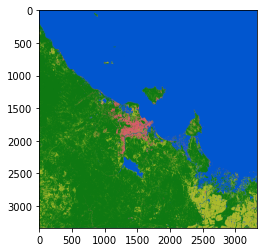

In [49]:
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))

### Loop thorough all site and export a geotiff

In [51]:
with open("au_test_sites.yaml", "r") as f:
    config = yaml.safe_load(f)

In [52]:
# Run for multiple years

for year in ["2015"]:
    # Run for all sites
    for i, site_name in enumerate(config.keys()):

        print("[{:02}/{:02}] {}".format(i+1, len(config.keys()),site_name))

        predicted = run_classification_for_site(site_name, classifier=classifier,
                                                year=year,
                                                model_variable_names=model_variable_names)

        # Get only cultivated layer
        cultivated = predicted.where(predicted == 111)

        out = cultivated.isel(time=0).transpose()
        out = cultivated.to_dataset(name="cultivated")
        out.attrs['crs']=geometry.CRS("EPSG:3577")
        out = out.isel(time=0)

        helpers.write_geotiff(os.path.join(working_dir,
                                           '{}_cultivated_{}.tif'.format(site_name.lower().replace(' ','_'), year)),
                              out)

[01/18] Ayr
[########################################] | 100% Completed | 12.0s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[02/18] Diamantina
[########################################] | 100% Completed | 13.0s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[03/18] Gwydir
[########################################] | 100% Completed | 14.0s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[04/18] Leichhardt
[########################################] | 100% Completed | 12.4s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[05/18] Kakadu
[########################################] | 100% Completed | 14.6s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[06/18] Hobart
[########################################] | 100% Completed | 13.2s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[07/18] Perth
[########################################] | 100% Completed | 15.0s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[08/18] Murray Valley
[########################################] | 100% Completed | 15.9s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[09/18] Adelaide
[########################################] | 100% Completed | 15.2s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[10/18] Lake Eyre
[########################################] | 100% Completed |  9.5s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[11/18] Blue mountains
[########################################] | 100% Completed | 13.6s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[12/18] Australian Alps
[########################################] | 100% Completed | 12.8s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[13/18] Collier Range
[########################################] | 100% Completed | 11.7s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[14/18] Coorong
[########################################] | 100% Completed | 13.7s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[15/18] Brisbane
[########################################] | 100% Completed | 13.1s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[16/18] Dundas
[########################################] | 100% Completed | 13.4s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[17/18] Kalgoorlie
[########################################] | 100% Completed |  3.9s
[18/18] Kangaroo Island


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


[########################################] | 100% Completed | 44.6s


/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)
